In [109]:
from nltk.tokenize import RegexpTokenizer
import string
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
import re
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
np.random.seed(1)

from numpy import array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D, Bidirectional, Embedding
from tensorflow.keras.layers import Flatten
import tensorflow as tf
from tensorflow.keras.models import Sequential

%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mysentimentdata/SentimentAnalysisDataset100000.csv
/kaggle/input/sentiment/SentimentAnalysisDataset100000.csv


In [110]:
df=pd.read_csv('/kaggle/input/mysentimentdata/SentimentAnalysisDataset100000.csv')

In [111]:
df

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...
...,...,...,...
12850,15428,1,: everything in the van....off to the seaside
12851,15429,0,: excited for the new moon trailer
12852,15430,1,: fair thee well night sky and moon. until tom...
12853,15431,0,: feels happy with the outcome..and it gets be...


In [112]:
df = df.sample(frac=1)
df = df[:200000]

In [113]:
print("Data Shape:", df.shape)

Data Shape: (12855, 3)


In [114]:
df["Sentiment"].unique()

array([1, 0])

In [115]:
df["Sentiment"] = df["Sentiment"].replace(4,1)
df.head()

,ItemID,Sentiment,SentimentText
8456,8964,1,&quot;my name is Tony!!!!!! ...not hey!!!!&quo...
6900,7244,0,#TweetDeck keeps starting below my taskbar in ...
4406,4663,1,your not coming to the party
4233,4490,0,totally upset
3407,3660,0,its soooo cold out &amp; my bed is soooo warm...


In [116]:
df.describe()

,ItemID,Sentiment
count,12855.000000,12855.000000
mean,6916.452509,0.446441
std,4027.521903,0.497143
min,1.000000,0.000000
25%,3462.500000,0.000000
50%,6759.000000,0.000000
75%,10284.500000,1.000000
max,15432.000000,1.000000


In [117]:
sent = df["Sentiment"].value_counts()
sent

Sentiment
0    7116
1    5739
Name: count, dtype: int64

In [118]:
t_df = df[['SentimentText',"Sentiment"]]
t_df.shape
t_df.head(5)

,SentimentText,Sentiment
8456,&quot;my name is Tony!!!!!! ...not hey!!!!&quo...,1
6900,#TweetDeck keeps starting below my taskbar in ...,0
4406,your not coming to the party,1
4233,totally upset,0
3407,its soooo cold out &amp; my bed is soooo warm...,0


In [119]:
t_df = t_df[t_df["Sentiment"] != ""]
t_df['SentimentText'] = t_df['SentimentText'].str.lower()
print(t_df.shape)
t_df.head(5)

(12855, 2)


,SentimentText,Sentiment
8456,&quot;my name is tony!!!!!! ...not hey!!!!&quo...,1
6900,#tweetdeck keeps starting below my taskbar in ...,0
4406,your not coming to the party,1
4233,totally upset,0
3407,its soooo cold out &amp; my bed is soooo warm...,0


In [120]:
pos = t_df[t_df['Sentiment'] == 1]
neg = t_df[t_df['Sentiment'] <= 1]

print("Positive Sentiments = ", len(pos))
print("\nNegative Sentiments = ", len(neg))


Positive Sentiments =  5739

Negative Sentiments =  12855


In [121]:
t_df.SentimentText=t_df.SentimentText.astype(str)
t_df.head()

,SentimentText,Sentiment
8456,&quot;my name is tony!!!!!! ...not hey!!!!&quo...,1
6900,#tweetdeck keeps starting below my taskbar in ...,0
4406,your not coming to the party,1
4233,totally upset,0
3407,its soooo cold out &amp; my bed is soooo warm...,0


In [122]:
t_label = t_df.Sentiment.factorize()
t_label

(array([0, 1, 0, ..., 0, 0, 0]), Index([1, 0], dtype='int64'))

In [123]:
t = t_df.SentimentText.values
t

array(['&quot;my name is tony!!!!!! ...not hey!!!!&quot; -  poor tony ',
       "#tweetdeck keeps starting below my taskbar in vista.  moving it and closing it again doesn't fix the issue. ",
       ' your not coming to the party ', ...,
       "#eu09 if its true that the tories are top in wales - i don't think i'll stop laughing until tuesday - ironic does even start to cover it! ",
       '&quot;teachers may access...blogs with educational value but are not allowed to have their own&quot; http://is.gd/ckly i will not tweet in class ',
       '- about to pop in a movie &amp; chill a bit... get it innnnn.! call n text '],
      dtype=object)

In [124]:
tt = t_df.SentimentText.values
tr = Tokenizer(num_words=5000)
tr.fit_on_texts(tt)
vocab_size = len(tr.word_index) + 1
enc_docs = tr.texts_to_sequences(tt)
pad_seq = pad_sequences(enc_docs, maxlen=200)

In [125]:
print(tr.word_index)

{'i': 1, 'quot': 2, 'to': 3, 'the': 4, 'a': 5, 'my': 6, 'and': 7, 'is': 8, 'you': 9, 'in': 10, 'of': 11, 'it': 12, 'me': 13, 'for': 14, 'on': 15, 'so': 16, 'that': 17, 'be': 18, 'have': 19, 'this': 20, 'but': 21, "i'm": 22, 'not': 23, 'just': 24, 'amp': 25, 'http': 26, 'with': 27, 'all': 28, 'now': 29, 'up': 30, 'at': 31, 'was': 32, 'love': 33, 'like': 34, 'are': 35, 'day': 36, 'no': 37, 'get': 38, 'out': 39, 'good': 40, 'lt': 41, 'do': 42, 'go': 43, "it's": 44, 'your': 45, 'one': 46, 'when': 47, 'what': 48, '3': 49, 'from': 50, "don't": 51, 'time': 52, 'today': 53, 'we': 54, 'im': 55, 'got': 56, 'com': 57, 'want': 58, 'going': 59, '2': 60, 'will': 61, 'can': 62, 'know': 63, 'if': 64, 'back': 65, 'more': 66, 'work': 67, 'has': 68, "can't": 69, 'am': 70, 'u': 71, 'still': 72, 'as': 73, 'new': 74, 'some': 75, 'about': 76, 'how': 77, 'they': 78, 'lol': 79, 'see': 80, 'really': 81, 'its': 82, 'by': 83, 'need': 84, 'miss': 85, 'why': 86, 'had': 87, 'twitter': 88, 'sad': 89, 'followfriday': 

In [126]:
print(tt[0])
print(enc_docs[0])

&quot;my name is tony!!!!!! ...not hey!!!!&quot; -  poor tony 
[2, 6, 402, 8, 2077, 23, 384, 2, 377, 2077]


In [127]:
print(pad_seq[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    2    6  402    8 2077   23
  384 

In [128]:
tr = Tokenizer(num_words=1500, split=' ')
tr.fit_on_texts(df['SentimentText'].values)
X = tr.texts_to_sequences(t_df['SentimentText'])
X = pad_sequences(X)

In [129]:
from sklearn.preprocessing import LabelEncoder
Le = LabelEncoder()
y = Le.fit_transform(t_df["Sentiment"])

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 42)

In [131]:
labelencoder = LabelEncoder()
df1 = t_df.assign(sentiment = labelencoder.fit_transform(t_df["Sentiment"]))

In [132]:
docs = t_df['SentimentText']
labels = array(t_df['Sentiment'])

In [133]:
vocab_size = 5000
embedding_size=32
max_words=500
embedding_vector_length = 32
model = Sequential()#Initializing the RNN Algorithm 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])# Compiling the RNN
print(model.summary()) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 32)           160000    
                                                                 
 spatial_dropout1d_2 (Spati  (None, 200, 32)           0         
 alDropout1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 176651 (690.04 KB)
Trainable params: 176651 (690.04 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [134]:
no_epochs = 10
b_size = 32
val=0.2

In [135]:
#Fitting the RNN into the Training Set
history = model.fit(pad_seq,t_label[0],validation_split=val, epochs=no_epochs, batch_size=b_size)

Epoch 1/10
322/322 [==============================] - 57s 167ms/step - loss: 0.2456 - accuracy: 0.5523 - val_loss: 0.2436 - val_accuracy: 0.5651
Epoch 2/10
322/322 [==============================] - 53s 165ms/step - loss: 0.2321 - accuracy: 0.6053 - val_loss: 0.2446 - val_accuracy: 0.5683
Epoch 3/10
322/322 [==============================] - 53s 166ms/step - loss: 0.2124 - accuracy: 0.6645 - val_loss: 0.2506 - val_accuracy: 0.5636
Epoch 4/10
322/322 [==============================] - 53s 165ms/step - loss: 0.1937 - accuracy: 0.7026 - val_loss: 0.2572 - val_accuracy: 0.5574
Epoch 5/10
322/322 [==============================] - 53s 166ms/step - loss: 0.1783 - accuracy: 0.7379 - val_loss: 0.2679 - val_accuracy: 0.5784
Epoch 6/10
322/322 [==============================] - 53s 166ms/step - loss: 0.1662 - accuracy: 0.7588 - val_loss: 0.2771 - val_accuracy: 0.5648
Epoch 7/10
322/322 [==============================] - 53s 165ms/step - loss: 0.1574 - accuracy: 0.7720 - val_loss: 0.2899 - val_ac

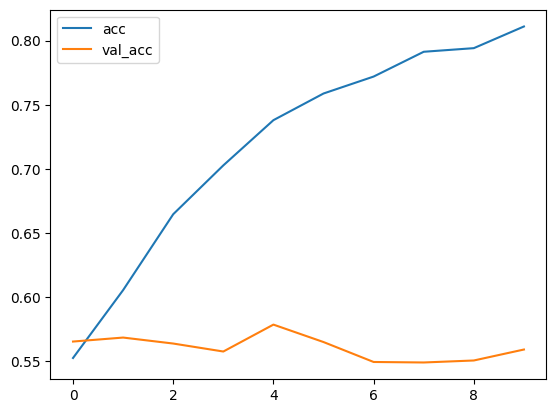

In [136]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

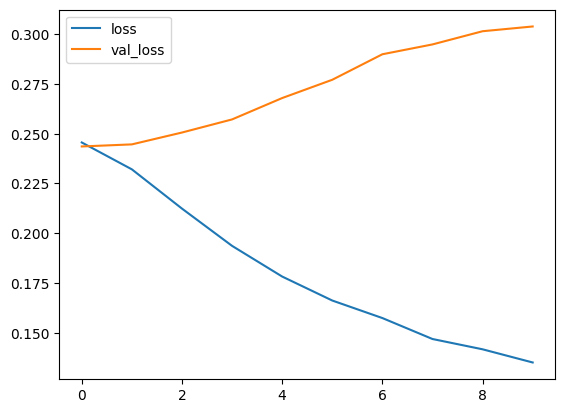

In [137]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [138]:
def predict_sentiment(text):
    tw = tr.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", t_label[1][prediction])

In [139]:
t_sentence1 = "I enjoyed this experience."
predict_sentiment(t_sentence1)

1/1 [==============================] - 0s 288ms/step
Predicted label:  0


In [140]:
t_sentence2 = "This is the best experience ever!"
predict_sentiment(t_sentence2)

1/1 [==============================] - 0s 40ms/step
Predicted label:  0


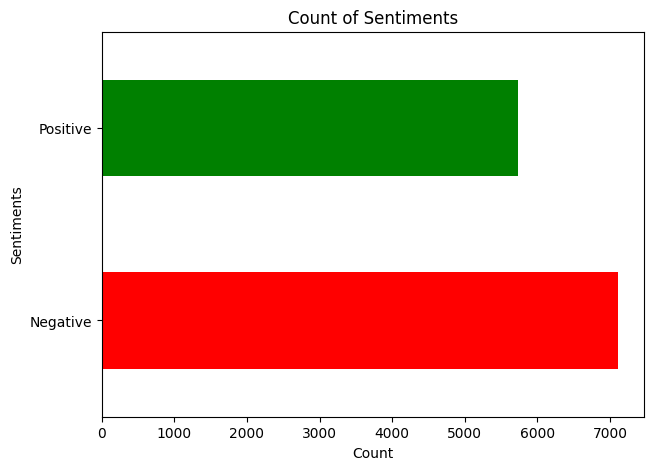

In [141]:
fig = plt.figure(figsize=(7,5))
index = [0,1]
color = ['red','green']
t_df["Sentiment"].value_counts().plot(kind='barh',color = color)
plt.yticks(index,['Negative','Positive'])
plt.title('Count of Sentiments')
plt.ylabel('Sentiments')
plt.xlabel('Count')
plt.grid(False)
plt.show()

Text(0.5, 1.0, 'Distribution of Sentiments')

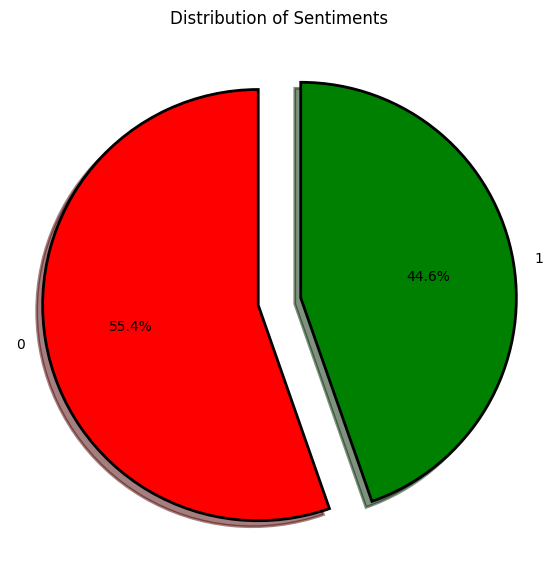

In [142]:
fig = plt.figure(figsize=(7,7))
index = [0,1]
colors = ('red','green')
wp={'linewidth':2, 'edgecolor': 'black'}
tags=t_df['Sentiment'].value_counts()
explode = (0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors,startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title('Distribution of Sentiments')

In [143]:
from collections import Counter
all_words = []
for line in list(t_df['SentimentText']):
    words = line.split()
    for word in words:
      if(len(word)>2):
        all_words.append(word.lower())
Counter(all_words).most_common(20)

[('the', 3989),
 ('and', 2371),
 ('for', 1482),
 ('you', 1467),
 ('have', 927),
 ('that', 918),
 ('this', 859),
 ('not', 854),
 ("i'm", 838),
 ('but', 828),
 ('just', 821),
 ('with', 786),
 ('was', 693),
 ('all', 660),
 ('&amp;', 616),
 ('like', 616),
 ('are', 588),
 ('love', 564),
 ('get', 558),
 ('now', 499)]

In [144]:
t_df['SentimentText'] = t_df['SentimentText'].astype('str')
stp = set(stopwords.words('english'))
print(stp)

{"don't", 'most', 'all', "you'll", 'aren', 'while', 'out', 'about', 'at', 'just', "haven't", 'couldn', "shan't", 'whom', 'they', 'it', 'yours', 'does', 'ourselves', "wasn't", "won't", "you'd", 'because', 'not', 'his', 'wasn', 'the', 'y', 'ours', 'no', "should've", 'during', 'won', 'very', 'wouldn', 'to', 'up', 'me', 'if', 'of', 'ma', 'don', 'didn', 'were', "needn't", 'those', 've', 'an', 'such', 'further', 'you', 'which', 'mustn', 'was', 'only', 'themselves', 'any', 'is', 'each', 'shan', 'on', "wouldn't", 'herself', 'she', 'these', 'its', 'be', 'he', 'some', 'should', 'being', 'myself', 'than', 'yourself', 'down', 'doesn', 'before', 'needn', 'against', 'what', 'until', 'off', 'yourselves', 'your', 'same', 'weren', "mustn't", 'over', 'once', 'this', 'him', 'why', 'who', 'few', 'itself', 'are', 'having', 're', 'nor', 'that', "she's", 'their', "hadn't", 'there', 'here', 'or', 'where', 'under', "hasn't", 'below', 'again', 'himself', 'hadn', 'too', 'both', 'how', 'haven', "didn't", 'hers', 

In [145]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [146]:
trn = t_df
tst = t_df
trn.head(5)

,SentimentText,Sentiment
8456,&quot;my name is tony!!!!!! ...not hey!!!!&quo...,1
6900,#tweetdeck keeps starting below my taskbar in ...,0
4406,your not coming to the party,1
4233,totally upset,0
3407,its soooo cold out &amp; my bed is soooo warm...,0


In [147]:
trn['Sentiment'].unique()

array([1, 0])

In [148]:
data_pos = trn[trn['Sentiment'] == 1]
data_neg = trn[trn['Sentiment'] <= 0]

In [149]:
ds = pd.concat([data_pos, data_neg])
ds['SentimentText']=ds['SentimentText'].str.lower()
ds['SentimentText'].tail()

4225      today's shooting postponed after art basel! h...
144       &quot;i want you so bad it's driving me  mad&...
2895      i think i'm getting that stomach virus going ...
10955    &quot;air france have 'lost hope' of finding m...
905       all that carpet cleaning for nothing... the c...
Name: SentimentText, dtype: object

In [150]:
swlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [151]:
stpwdS = set(swlist)
def cleaning_stpwds(text):
    return " ".join([word for word in str(text).split() if word not in stpwdS])
ds['SentimentText'] = ds['SentimentText'].apply(lambda text: cleaning_stpwds(text))
ds['SentimentText'].head()

8456     &quot;my name tony!!!!!! ...not hey!!!!&quot; ...
4406                                      not coming party
10018    &quot;you miss 100% shots don't take.&quot; th...
12615    -.- no idea...i'm sitting home alone lol bored...
8370     #follow friday... follow @benjamin_cook cos he...
Name: SentimentText, dtype: object

In [152]:
eng_punc = string.punctuation
punct_list = eng_punc
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punct_list)
    return text.translate(translator)
ds['SentimentText']= ds['SentimentText'].apply(lambda x: cleaning_punctuations(x))
ds['SentimentText'].tail()

4225     todays shooting postponed art basel hope los a...
144                     quoti want bad its driving madquot
2895     think im getting stomach virus going aroundnoo...
10955    quotair france lost hope finding missing plane...
905      carpet cleaning nothing carpets smell bad old ...
Name: SentimentText, dtype: object

In [153]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
ds['SentimentText'] = ds['SentimentText'].apply(lambda x: cleaning_repeating_char(x))
ds['SentimentText'].tail()

4225     todays shooting postponed art basel hope los a...
144                     quoti want bad its driving madquot
2895     think im getting stomach virus going aroundnoo...
10955    quotair france lost hope finding missing plane...
905      carpet cleaning nothing carpets smell bad old ...
Name: SentimentText, dtype: object

In [154]:
def cleaning_URLs(trn):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',trn)
ds['SentimentText'] = ds['SentimentText'].apply(lambda x: cleaning_URLs(x))
ds['SentimentText'].tail()

4225     todays shooting postponed art basel hope los a...
144                     quoti want bad its driving madquot
2895     think im getting stomach virus going aroundnoo...
10955    quotair france lost hope finding missing plane...
905      carpet cleaning nothing carpets smell bad old ...
Name: SentimentText, dtype: object

In [155]:
def cleaning_numbers(trn):
    return re.sub('[0-9]+', '', trn)
ds['SentimentText'] = ds['SentimentText'].apply(lambda x: cleaning_numbers(x))
ds['SentimentText'].tail()

4225     todays shooting postponed art basel hope los a...
144                     quoti want bad its driving madquot
2895     think im getting stomach virus going aroundnoo...
10955    quotair france lost hope finding missing plane...
905      carpet cleaning nothing carpets smell bad old ...
Name: SentimentText, dtype: object

In [156]:
tr = RegexpTokenizer(r'w+')
ds['SentimentText'] = ds['SentimentText'].apply(tr.tokenize)
ds['SentimentText'].head()

8456         []
4406         []
10018       [w]
12615        []
8370     [w, w]
Name: SentimentText, dtype: object

In [157]:
X=trn.SentimentText
y=trn['Sentiment']

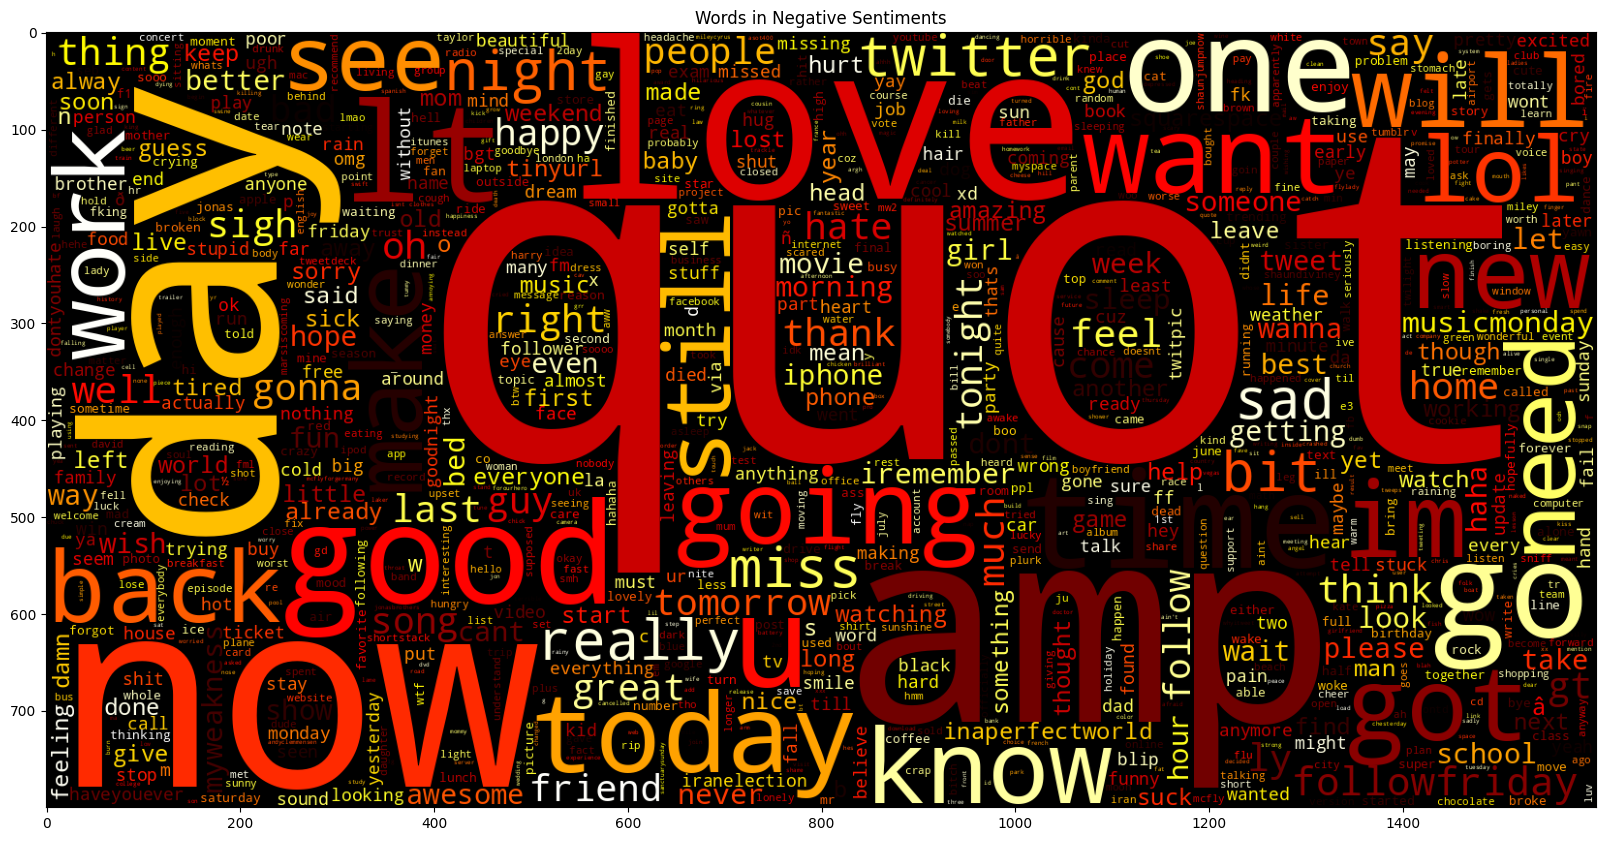

In [158]:
data_neg = trn['SentimentText'][:800000]
data_neg=data_neg.astype(str)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,background_color="black",colormap = 'hot', collocations=False).generate(" ".join(data_neg))
plt.title('Words in Negative Sentiments')
plt.imshow(wc)

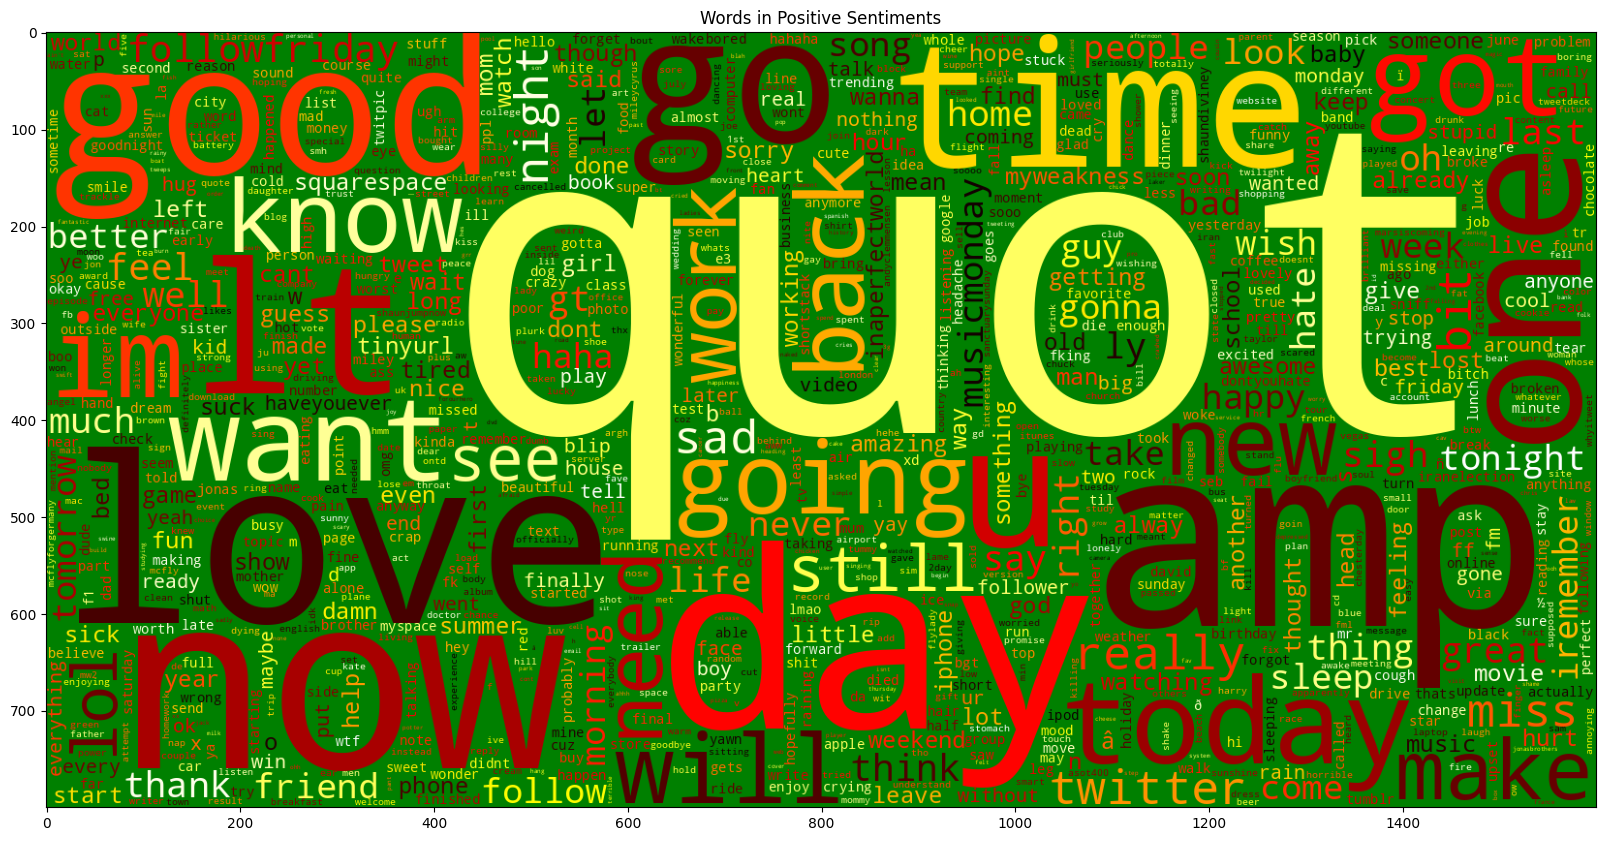

In [159]:
data_pos = trn['SentimentText'][:800000]
data_pos=data_pos.astype(str)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, background_color="green",colormap = 'hot', collocations=False).generate(" ".join(data_pos))
plt.title('Words in Positive Sentiments')
plt.imshow(wc)